In [5]:
from dotenv import load_dotenv

import dspy
import pandas as pd

from dspy.datasets import HotPotQA
from hotpotqa_agent import hotpotqa_agent

import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv(".env")

False

In [2]:
ds = HotPotQA(train_size=0, test_size=0, dev_size=100, eval_seed=2025)

/Users/roshankern/Desktop/Github/dspy-lora-agent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'hotpot_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'hotpot_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'hotpot_qa' isn'

In [3]:
NUM_EXAMPLES = 10

lm_configs = {
    "gemini-flash": dspy.LM("gemini/gemini-2.5-flash-preview-05-20"),
    "llama3b": dspy.LM(
        "openai/unsloth/Llama-3.2-3B-Instruct",
        api_key="",
        api_base="https://roshan-kern--hf-endpoint-serve-original-model.modal.run/v1",
    ),
    "llama3b-sft": dspy.LM(
        "openai/rshn-krn/hotpotqa-agent-sft-llm",
        api_key="",
        api_base="https://roshan-kern--hf-endpoint-serve-sft-model.modal.run/v1",
    ),
}

# Build results dataframe
results = []
for i, ex in enumerate(ds.dev[:NUM_EXAMPLES]):
    row = {"question": ex["question"], "gold_answer": ex["answer"]}

    for model_name, lm in lm_configs.items():
        dspy.configure(lm=lm, temperature=0)
        pred = hotpotqa_agent(question=ex["question"])

        row[f"{model_name}__answer"] = pred.answer
        row[f"{model_name}__correct"] = ex["answer"].lower() in pred.answer.lower()
        row[f"{model_name}__trace_steps"] = len(pred.trajectory) // 4

    results.append(row)

eval_df = pd.DataFrame(results)
eval_df

,question,gold_answer,gemini-flash__answer,gemini-flash__correct,gemini-flash__trace_steps,llama3b__answer,llama3b__correct,llama3b__trace_steps,llama3b-sft__answer,llama3b-sft__correct,llama3b-sft__trace_steps
0,Pehchaan: The Face of Truth stars Vinod Khanna...,Raveena Tandon,Raveena Tandon,True,2,Raveena Tandon,True,5,Raveena Tandon,True,2
1,What is the name of the person who helped work...,Michael Fokine,Michel Fokine,False,3,Frederick Ashton,False,5,Michel Fokine.,False,3
2,Trim is a transitway station in the east end o...,"934,243","934,243",True,3,"Unfortunately, the provided information does n...",False,5,"The city of Ottawa, Ontario, had a population ...",True,3
3,Which French crime drama starred Antonythasan ...,Dheepan,Dheepan,True,2,The answer is not explicitly stated in the pro...,False,5,Dheepan,True,2
4,What occupation do Dustin Kensrue and Jimmy Ur...,singer,Musician,False,3,They share the occupation of being musicians.,False,5,The occupation Dustin Kensrue and Jimmy Urine ...,False,3
5,what has a larger popoulation: Zhangqiu Distri...,Zhangqiu,Zhangqiu District,True,3,"Yumen City has a larger population, with a pop...",True,5,Zhangqiu District has a larger population than...,True,3
6,Are Anyang and Fenyang both in the same provin...,no,"No, Anyang is in Henan province and Fenyang is...",True,3,"Yes, Both Anyang and Fenyang are located in th...",False,5,"No, Anyang and Fenyang are not in the same pro...",True,3
7,What is the name of the South Korean-Chinese b...,EXO,EXO,True,3,EXO,True,5,EXO,True,3
8,Who was the composer of the 2011 British-Ameri...,Chris Bacon,Chris Bacon,True,2,Chris Bacon,True,5,Chris Bacon,True,3
9,Who is credited for The Internship role that c...,Shawn Levy,Shawn Levy,True,3,Owen Wilson is credited for The Internship rol...,False,5,I cannot find the actor who played Akiva Schaf...,False,5


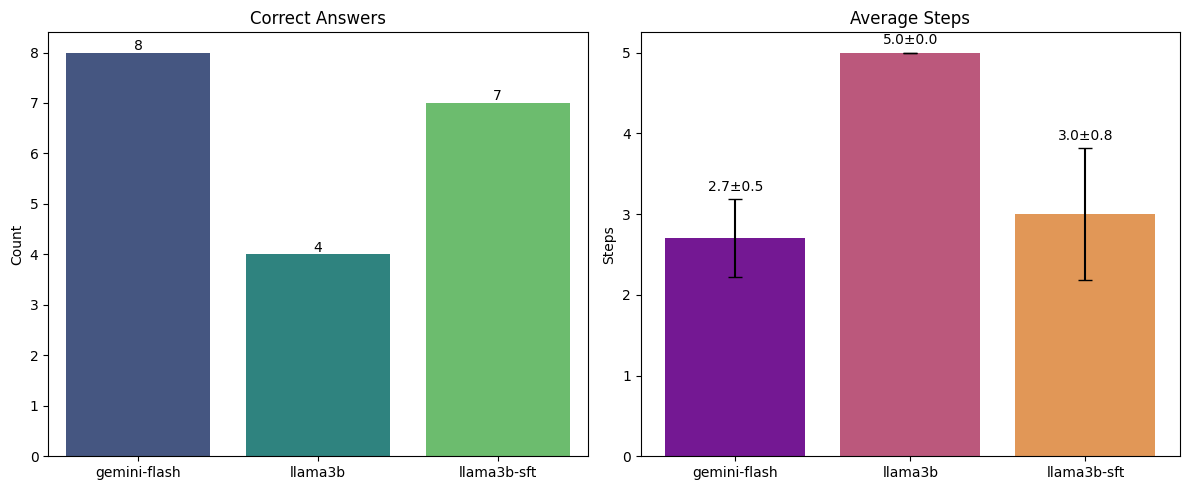

gemini-flash: 8/10 correct (80%), 2.7±0.5 steps
llama3b: 4/10 correct (40%), 5.0±0.0 steps
llama3b-sft: 7/10 correct (70%), 3.0±0.8 steps


In [6]:
model_names = list(lm_configs.keys())

# Calculate metrics
accuracy_data = [eval_df[f"{model}__correct"].sum() for model in model_names]
steps_stats = [
    (eval_df[f"{model}__trace_steps"].mean(), eval_df[f"{model}__trace_steps"].std())
    for model in model_names
]

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
sns.barplot(x=model_names, y=accuracy_data, ax=ax1, palette="viridis")
ax1.set_title("Correct Answers")
ax1.set_ylabel("Count")
for i, v in enumerate(accuracy_data):
    ax1.text(i, v + 0.05, str(v), ha="center")

# Steps plot with error bars
steps_mean, steps_std = zip(*steps_stats)
sns.barplot(x=model_names, y=steps_mean, ax=ax2, palette="plasma")
ax2.errorbar(
    range(len(model_names)),
    steps_mean,
    yerr=steps_std,
    fmt="none",
    color="black",
    capsize=5,
)
ax2.set_title("Average Steps")
ax2.set_ylabel("Steps")
for i, (m, s) in enumerate(steps_stats):
    ax2.text(i, m + s + 0.1, f"{m:.1f}±{s:.1f}", ha="center")

plt.tight_layout()
plt.show()

# Summary
for i, model in enumerate(model_names):
    acc = accuracy_data[i]
    m, s = steps_stats[i]
    print(
        f"{model}: {acc}/{NUM_EXAMPLES} correct ({acc / NUM_EXAMPLES * 100:.0f}%), {m:.1f}±{s:.1f} steps"
    )